In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [2]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from matplotlib.patches import ConnectionPatch
from scipy.stats import pearsonr
from scipy import stats
from loading import load_session_data
from target import get_spike_counts, build_silence_and_noise_events, \
        get_idxs_of_event_periods, get_spike_times_at
np.set_printoptions(suppress=True)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
sessions = [s for s in selected_009266.keys()]
sessions.sort()
sessions

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

In [5]:
dst_path = "/home/sobolev/nevermind/AG_Pecka/data/processed/"
session  = sessions[0]
animal   = session.split('_')[0]
meta_file  = os.path.join(dst_path, animal, session, 'meta.h5')
units_file = os.path.join(dst_path, animal, session, 'units.h5')
psth_file = os.path.join(dst_path, animal, session, 'analysis', 'psth.h5')

with h5py.File(meta_file, 'r') as f:
    sound_events = np.array(f['processed']['sound_events'])
    #trials       = np.array(f['processed']['trial_idxs'])
    #cfg          = json.loads(f['processed'].attrs['parameters'])
    tgt_mx       = np.array(f['processed']['target_matrix'])
    tl           = np.array(f['processed']['timeline'])
    
# load units
unit_names, single_units, spike_times = [], {}, {}
with h5py.File(units_file, 'r') as f:
    unit_names = [x for x in f]

with h5py.File(units_file, 'r') as f:
    for unit_name in unit_names:
        spike_times[unit_name]  = np.array(f[unit_name][H5NAMES.spike_times['name']])
        single_units[unit_name] = np.array(f[unit_name][H5NAMES.inst_rate['name']])

In [6]:
def get_shuffled(spiketrain):
    # shuffle spike times preserving inter-spike intervals
    ISIs = np.diff(spiketrain)
    np.random.shuffle(ISIs)
    return np.concatenate([[spiketrain[0]], spiketrain[0] + np.cumsum(ISIs)])

In [7]:
def compute_shuffled_metrics(strain, event_times, offset, bin_count, iter_count=1000):
    # psth with shuffled spike data
    psth_shuffled = np.zeros((iter_count, bin_count - 1))
    for i in range(iter_count):  # shuffle 1000 times
        shuffled = get_shuffled(strain)
        bins, psth = get_spike_counts(shuffled, event_times, hw=offset, bin_count=bin_count)
        psth_shuffled[i] = psth
        
    # percentiles
    confidence_5_0_low  = np.zeros(psth_shuffled.shape[1])
    confidence_2_5_low  = np.zeros(psth_shuffled.shape[1])
    confidence_95_0_high = np.zeros(psth_shuffled.shape[1])
    confidence_97_5_high = np.zeros(psth_shuffled.shape[1])
    for i, col in enumerate(psth_shuffled.T):
        confidence_5_0_low[i]  = np.percentile(col, 5)
        confidence_95_0_high[i] = np.percentile(col, 95)
        confidence_2_5_low[i]  = np.percentile(col, 2.5)
        confidence_97_5_high[i] = np.percentile(col, 97.5)
        
    # bins, shuffled mean, shuffled std, 0.025, 0.975, 0.05, 0.95 percentiles (p=0.05, p=0.0)
    return np.vstack([
        bins[:-1],  
        psth_shuffled.mean(axis=0),
        psth_shuffled.std(axis=0),
        confidence_2_5_low, 
        confidence_97_5_high,
        confidence_5_0_low, 
        confidence_95_0_high,
    ]).T

# Compute shuffled metrics

In [8]:
sessions = [s for s in selected_009266.keys()]
sessions.sort()
sessions

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

## Shuffle micro

In [9]:
selected = sessions[:1]
#selected.remove('009266_hippoSIT_2023-05-04_09-11-06')
selected

['009266_hippoSIT_2023-04-17_17-04-17']

In [10]:
offset     = 0.25
bin_count  = 31
event_type = 0
event_types = ['silence', 'BGR', 'TGT', 'noise']

In [30]:
for session in selected:
#     session_data = load_session_data(session)

#     tl = session_data['tl']
#     trials = session_data['trials']
#     cfg = session_data['cfg']
#     aeps_events = session_data['aeps_events']
#     tgt_matrix = session_data['tgt_matrix']
#     single_units = session_data['single_units']
#     spike_times = session_data['spike_times']
#     unit_names = session_data['unit_names']
#     h5_file = session_data['h5_file']

    # for micro - silence
    s_offset  = aeps_events[0][0]
    latency = 0.25
    drift = ((aeps_events[:, 0] - s_offset) % latency)[-1]
    p_sil, p_noi, p_bgr, p_tgt = build_silence_and_noise_events(tl, s_offset, latency, drift)
    #pulses_silence, pulses_noise = build_silence_and_noise_events(tl, s_offset, latency, drift)

    # shrink pulse times as there is no other events
    pulses_all = [p_sil, p_bgr, p_tgt, p_noi]
    pulses = pulses_all[event_type]
    shift = 0
    adjusted_pulses = pulses.copy()
    periods = get_idxs_of_event_periods(tl, event_type)
    sil_only_dur = (tl[periods[:, 1]][:, 0] - tl[periods[:, 0]][:, 0]).sum()
    for period in periods:
        idxs_tl_l, idxs_tl_r = period[0], period[1]

        idxs = np.where((pulses > tl[idxs_tl_l][0]) & (pulses < tl[idxs_tl_r][0]))[0]
        adjusted_pulses[idxs] -= tl[idxs_tl_l][0]  # align to time 0
        adjusted_pulses[idxs] += shift
        shift += tl[idxs_tl_r][0] - tl[idxs_tl_l][0]

    # compute shuffled stats for each unit
    for unit_name in unit_names[:]:
        # spikes during certain event type only
        strain = get_spike_times_at(tl, spike_times[unit_name], periods)
        strain = np.array([item for sublist in strain for item in sublist])  # flatten to one array
        data = compute_shuffled_metrics(strain, adjusted_pulses, sil_only_dur, offset=offset, bin_count=bin_count)

        with h5py.File(h5_file, 'a') as f:
            title = 'psth_shuffled_micro_in_%s' % event_types[event_type]
            if title in f['units'][unit_name]:
                del f['units'][unit_name][title]
            f['units'][unit_name].create_dataset(title, data=data)

        print(unit_name + '; ', end='')
    print('Session %s done' % session[-19:-9])

1-10; 1-11; 1-12; 1-13; 1-14; 1-15; 1-16; 1-17; 1-18; 1-19; 1-2; 1-20; 1-21; 1-22; 1-23; 1-24; 1-25; 1-26; 1-27; 1-28; 1-29; 1-3; 1-30; 1-31; 1-32; 1-4; 1-5; 1-6; 1-7; 1-8; 1-9; 2-10; 2-11; 2-12; 2-13; 2-14; 2-15; 2-16; 2-17; 2-18; 2-19; 2-2; 2-20; 2-21; 2-22; 2-23; 2-24; 2-25; 2-26; 2-27; 2-28; 2-29; 2-3; 2-30; 2-31; 2-32; 2-33; 2-34; 2-35; 2-4; 2-5; 2-6; 2-7; 2-8; 2-9; 3-10; 3-11; 3-2; 3-3; 3-4; 3-5; 3-6; 3-7; 3-8; 3-9; 4-2; 4-3; 5-2; 5-3; 6-10; 6-11; 6-12; 6-13; 6-2; 6-3; 6-4; 6-5; 6-6; 6-7; 6-8; 6-9; Session 2023-05-22 done
1-10; 1-11; 1-12; 1-13; 1-14; 1-15; 1-16; 1-17; 1-18; 1-19; 1-2; 1-20; 1-21; 1-22; 1-23; 1-3; 1-4; 1-5; 1-6; 1-7; 1-8; 1-9; 2-10; 2-11; 2-12; 2-13; 2-14; 2-15; 2-16; 2-17; 2-18; 2-19; 2-2; 2-20; 2-21; 2-22; 2-23; 2-24; 2-25; 2-26; 2-27; 2-28; 2-29; 2-3; 2-30; 2-31; 2-32; 2-33; 2-34; 2-35; 2-36; 2-37; 2-38; 2-39; 2-4; 2-40; 2-41; 2-42; 2-43; 2-44; 2-5; 2-6; 2-7; 2-8; 2-9; 3-2; 3-3; 3-4; 3-5; 5-2; 6-2; 6-3; 6-4; 6-5; 6-6; 6-7; Session 2023-05-23 done
1-10; 1-11; 1

## Shuffle macro

In [222]:
selected = sessions[-5:-5]
selected

[]

In [223]:
offset    = 7.25
bin_count = 30

In [224]:
for session in selected:
    session_data = load_session_data(session)

    tl = session_data['tl']
    trials = session_data['trials']
    cfg = session_data['cfg']
    aeps_events = session_data['aeps_events']
    tgt_matrix = session_data['tgt_matrix']
    single_units = session_data['single_units']
    spike_times = session_data['spike_times']
    unit_names = session_data['unit_names']
    h5_file = session_data['h5_file']
    
    event_times = tl[tgt_matrix[:, 0]][:, 0]

    for unit_name in unit_names[:]:
        strain = spike_times[unit_name]
        duration = tl[-1][0] - tl[0][0]
        data = compute_shuffled_metrics(strain, event_times, duration, offset=offset, bin_count=bin_count)

        with h5py.File(h5_file, 'a') as f:
            if 'psth_shuffled_tgt_onset' in f['units'][unit_name]:
                del f['units'][unit_name]['psth_shuffled_tgt_onset']
            f['units'][unit_name].create_dataset('psth_shuffled_tgt_onset', data=data)

        print(unit_name + '; ', end='')
    print('Session %s done' % session[-19:-9])

## Choose target selective units

In [14]:
tgt_units       = []
idxs_succ       = np.where(tgt_matrix[:, 4] == 1)[0]
tgt_succ_times  = tl[tgt_matrix[idxs_succ][:, 0]][:, 0]

for unit_name in unit_names:
    with h5py.File(h5_file, 'r') as f:
        shuffled = np.array(f['units'][unit_name]['psth_shuffled_tgt_onset'])
    
    # based on success trials
    strain = spike_times[unit_name]
    bins, counts_enter = get_spike_counts(strain, tgt_succ_times, hw=offset, bin_count=bin_count)
    zero_bin_idx = len(bins[bins < 0]) - 1

    if counts_enter[zero_bin_idx] > shuffled[zero_bin_idx][3]: #or \
        #counts_enter[zero_bin_idx + 1] > shuffled[zero_bin_idx + 1][3]:
        tgt_units.append(unit_name)

## Test plotting

In [94]:
pulses = sound_events[sound_events[:, 1] == event_type][:, 0]
shift = 0
periods = get_idxs_of_event_periods(tl, event_type)

# first shrink all selected pulses as if there is no other periods
adjusted_pulses = pulses.copy()
for period in periods:
    idxs_tl_l, idxs_tl_r = period[0], period[1]

    idxs = np.where((pulses > tl[idxs_tl_l][0]) & (pulses < tl[idxs_tl_r][0]))[0]
    adjusted_pulses[idxs] -= tl[idxs_tl_l][0]  # align to time 0
    adjusted_pulses[idxs] += shift
    shift += tl[idxs_tl_r][0] - tl[idxs_tl_l][0]

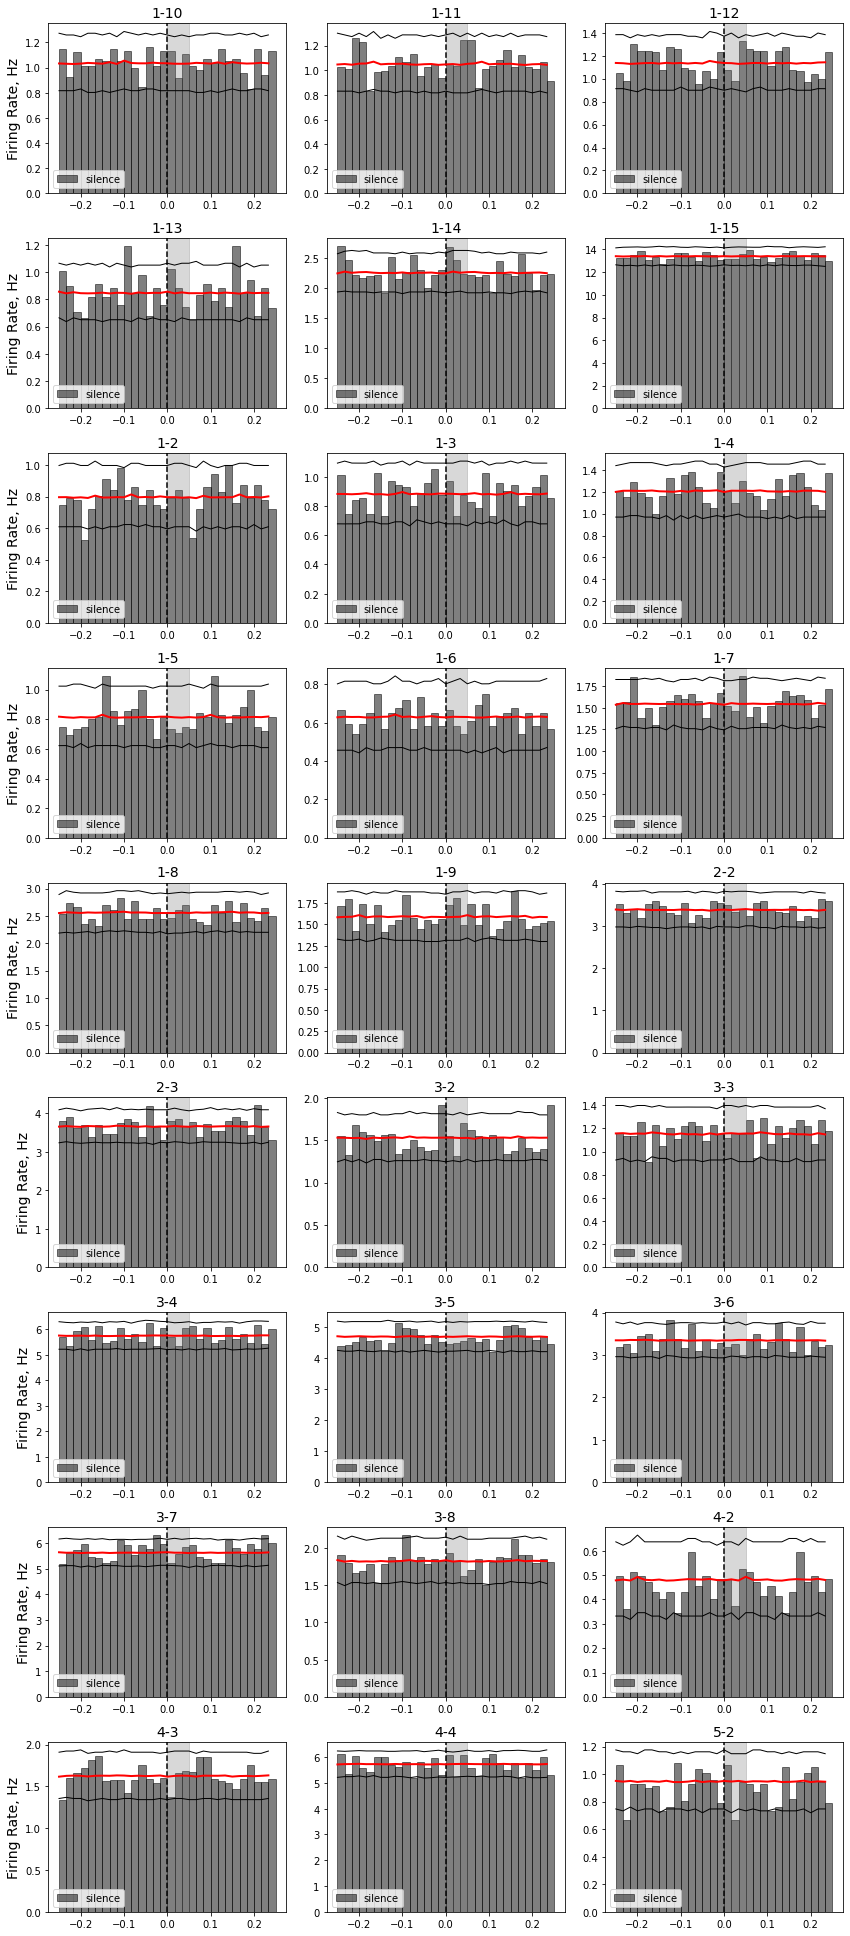

In [95]:
units_to_plot = unit_names[:]

cols = 3
rows = int(np.ceil(len(units_to_plot)/cols))
fig = plt.figure(figsize=(12, rows*3))

for i, unit_name in enumerate(units_to_plot):
    # get only spike during selected period type
    strain = get_spike_times_at(tl, spike_times[unit_name], periods)
    strain = np.array([item for sublist in strain for item in sublist])  # flatten to one array

    # original PSTH
    bins, counts_A = get_spike_counts(strain, adjusted_pulses, hw=offset, bin_count=bin_count)

    # shuffled PSTH
    with h5py.File(psth_file, 'r') as f:
        shuffled = np.array(f[unit_name]['psth_shuffled_micro_%s_bc%d' % (event_types[event_type], bin_count)])
    
    ax = fig.add_subplot(rows, cols, i+1)
    ax.hist(bins[:-1], bins=bins, weights=counts_A, edgecolor='black', color='black', alpha=0.5, label='silence')
    ax.axvline(0, color='black', ls='--')
    ax.axvspan(0, 0.05, alpha=0.3, color='gray')
    ax.legend(loc='lower left')
    ax.plot(shuffled[:, 0], shuffled[:, 1], lw=2, color='red')
    ax.plot(shuffled[:, 0], shuffled[:, 3], lw=1, color='black')
    ax.plot(shuffled[:, 0], shuffled[:, 4], lw=1, color='black')
    if i % cols == 0:
        ax.set_ylabel("Firing Rate, Hz", fontsize=14)
    ax.set_title("%s" % unit_name, fontsize=14)        
        
fig.tight_layout()

In [81]:
session = sessions[0]
session

'009266_hippoSIT_2023-04-17_17-04-17'

In [17]:
event_type = -1
event_types = ['silence', 'BGR', 'TGT', 'noise']
hw, bc = 0.25, 31

session_data = load_session_data(session)

tl = session_data['tl']
trials = session_data['trials']
cfg = session_data['cfg']
aeps_events = session_data['aeps_events']
tgt_matrix = session_data['tgt_matrix']
single_units = session_data['single_units']
spike_times = session_data['spike_times']
unit_names = session_data['unit_names']
h5_file = session_data['h5_file']

# for micro - silence
s_offset  = aeps_events[0][0]
drift = ((aeps_events[:, 0] - s_offset) % hw)[-1]
p_sil, p_noi, p_bgr, p_tgt = build_silence_and_noise_events(tl, s_offset, hw, drift)

# shrink pulse times as there is no other events
pulses_all = [p_sil, p_bgr, p_tgt, p_noi]
pulses = pulses_all[event_type]
shift = 0
adjusted_pulses = pulses.copy()
periods = get_idxs_of_event_periods(tl, event_type)
for period in periods:
    idxs_tl_l, idxs_tl_r = period[0], period[1]

    idxs = np.where((pulses > tl[idxs_tl_l][0]) & (pulses < tl[idxs_tl_r][0]))[0]
    adjusted_pulses[idxs] -= tl[idxs_tl_l][0]  # align to time 0
    adjusted_pulses[idxs] += shift
    shift += tl[idxs_tl_r][0] - tl[idxs_tl_l][0]

In [18]:
# distort pulses
#adjusted_pulses *= 4/5.5

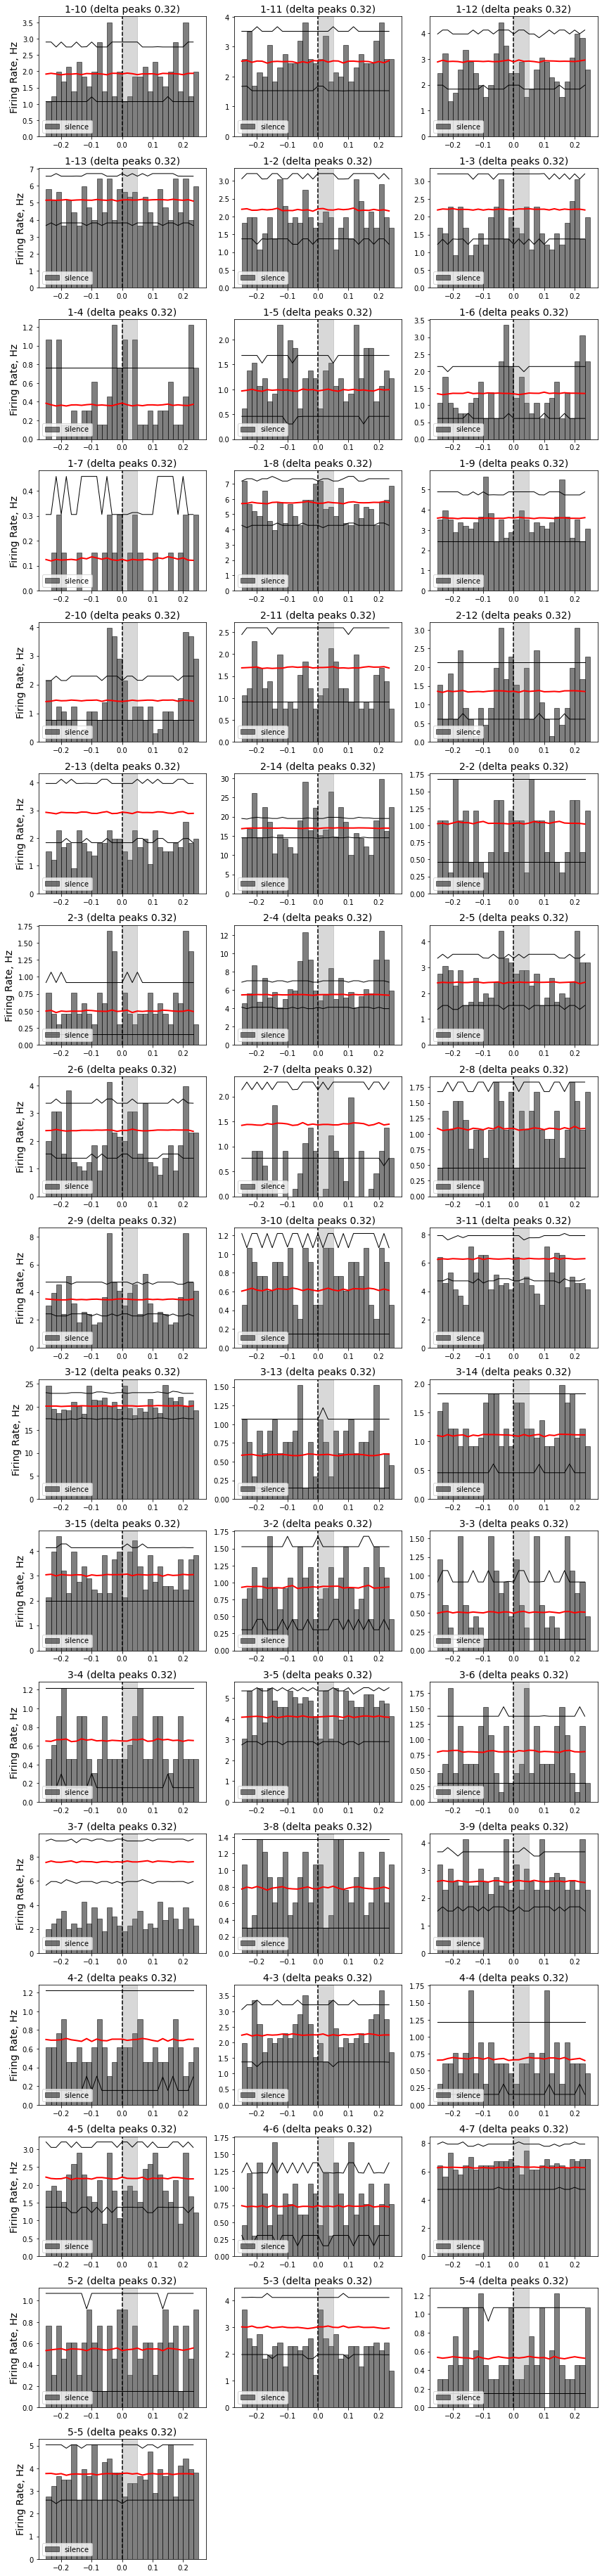

In [22]:
#units_to_plot = ['1-10', '1-11', '1-12', '1-13']
units_to_plot = unit_names[:]
#units_to_plot = ['1-14', '1-15', '1-21', '1-23', '1-29', '1-31', '1-6', '1-8', '2-17', '2-23', '3-2', '3-8', '3-9', '4-3', '6-2']
#m_nice_units  = ['1-10', '1-25', '1-4', '1-7', '1-9', '2-15', '2-26', '2-3', '2-4', '2-11', '2-22']
#units_to_plot = ['3-9', '3-2', '3-8', '1-31', '1-21', '1-29', '6-2', '4-3']

cols = 3
rows = int(np.ceil(len(units_to_plot)/cols))
fig = plt.figure(figsize=(12, rows*3))

for i, unit_name in enumerate(units_to_plot):
    #strain = spike_times[unit_name]
    strain = get_spike_times_at(tl, spike_times[unit_name], periods)
    strain = np.array([item for sublist in strain for item in sublist])  # flatten to one array

    # compute original
    #bins, counts_enter = get_spike_counts(strain, tl[tgt_matrix[:, 0]][:, 0], hw=7, bin_count=bin_count)
    #bins, counts_enter = get_spike_counts(strain, tl[tgt_matrix[idxs_succ][:, 0]][:, 0], hw=offset, bin_count=bin_count)
    #bins, counts_A = get_spike_counts(strain, pulses_silence, hw=offset, bin_count=bin_count)
    bins, counts_A = get_spike_counts(strain, adjusted_pulses, hw=hw, bin_count=bc)

    # get shuffled
    with h5py.File(h5_file, 'r') as f:
        shuffled = np.array(f['units'][unit_name]['psth_shuffled_micro_in_%s' % event_types[event_type]])
    
    ax = fig.add_subplot(rows, cols, i+1)
    ax.hist(bins[:-1], bins=bins, weights=counts_A, edgecolor='black', color='black', alpha=0.5, label='silence')
    ax.axvline(0, color='black', ls='--')
    ax.axvspan(0, 0.05, alpha=0.3, color='gray')
    ax.legend(loc='lower left')
    ax.plot(shuffled[:, 0], shuffled[:, 1], lw=2, color='red')
    ax.plot(shuffled[:, 0], shuffled[:, 3], lw=1, color='black')
    ax.plot(shuffled[:, 0], shuffled[:, 4], lw=1, color='black')
    if i % cols == 0:
        ax.set_ylabel("Firing Rate, Hz", fontsize=14)
        
    # plot max in each half
    half_w = int(len(bins)/2)
    peak_l, peak_r = bins[counts_A[:half_w].argmax()], bins[counts_A[half_w:].argmax() + half_w]
    #ax.axvline(peak_l, color='red')
    #ax.axvline(peak_r, color='red')
    
    ax.set_title("%s (delta peaks %.2f)" % (unit_name, peak_r - peak_l), fontsize=14)
        
fig.tight_layout()
#fig.savefig(os.path.join(report, 'Hall', 'profiles_silence_5Hz_peaks.png'), dpi=500)